# Assignment-3 RNN (LSTM-Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [7]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [8]:
df.head()

IPN31152N
DATE                 
1972-01-01     59.962
1972-02-01     67.061
1972-03-01     74.235
1972-04-01     78.112
1972-05-01     84.764

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [10]:
df.columns = ['Production']

In [11]:
df.head()

Production
DATE                  
1972-01-01      59.962
1972-02-01      67.061
1972-03-01      74.235
1972-04-01      78.112
1972-05-01      84.764

<AxesSubplot:xlabel='DATE'>

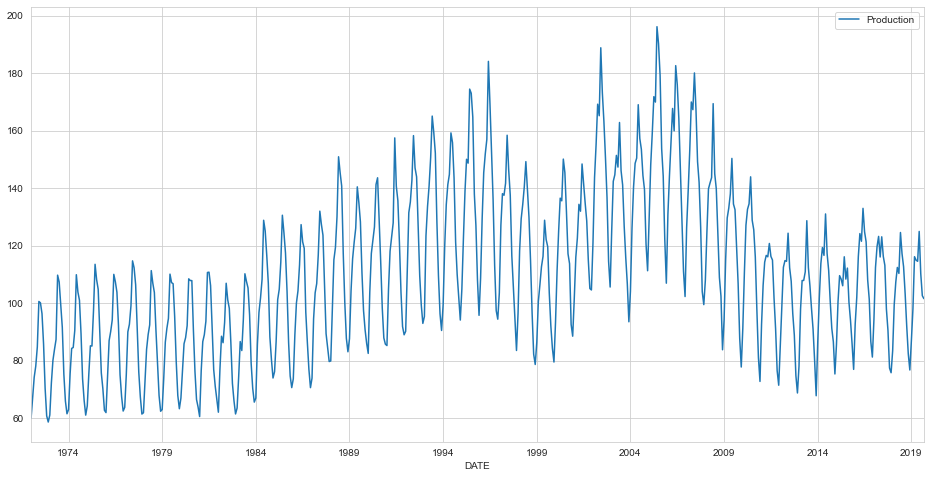

In [12]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [13]:
test_size = 18

In [14]:
test_ind = len(df)- test_size

In [15]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# help(TimeseriesGenerator)

In [21]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [40]:
X, y = generator[0]

In [41]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
n_features = 1

### with "tanh" activation function

In [44]:
model1 = Sequential()
model1.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mse')

In [45]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [46]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [47]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [48]:
model1.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 6s 8ms/step - loss: 0.0178 - val_loss: 0.0013
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 3/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 4/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 5/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0036 - val_loss: 0.0021


<AxesSubplot:>

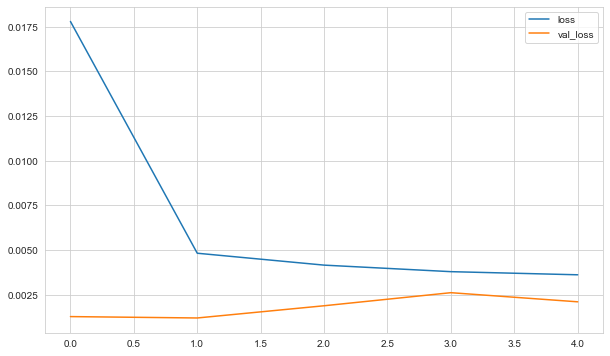

In [49]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [50]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model1.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [51]:
true_predictions = scaler.inverse_transform(test_predictions)

In [52]:
test['Predictions'] = true_predictions

In [53]:
test

Production  Predictions
DATE                               
2018-04-01     112.431      108.219
2018-05-01     110.354      110.784
2018-06-01     124.584      110.921
2018-07-01     117.222      107.156
2018-08-01     112.678      100.036
2018-09-01     103.312       90.364
2018-10-01      92.132       81.618
2018-11-01      82.435       76.185
2018-12-01      76.761       76.093
2019-01-01      86.999       80.005
2019-02-01      98.112       85.729
2019-03-01     116.172       91.262
2019-04-01     114.970       95.828
2019-05-01     114.561       98.902
2019-06-01     124.960       99.706
2019-07-01     110.263       97.797
2019-08-01     102.609       93.248
2019-09-01     101.587       86.937

<AxesSubplot:xlabel='DATE'>

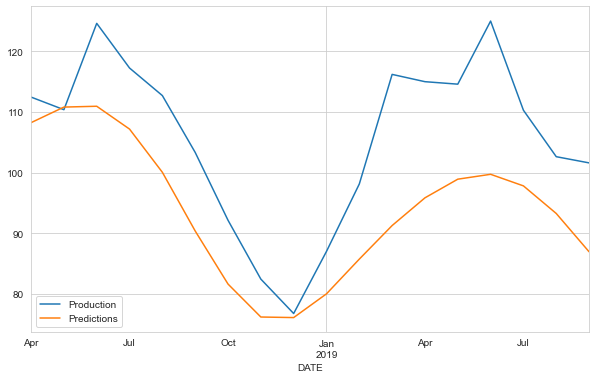

In [54]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [56]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [57]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: -0.01220607762831083 
mae: 11.789333609194314 
mse: 184.0668855001556 
rmse: 13.567125174485403


### with "relu" activation function

In [58]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [59]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [60]:
model2.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 5s 8ms/step - loss: 0.0206 - val_loss: 0.0028
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 3/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 4/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 5/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0044 - val_loss: 0.0094


<AxesSubplot:>

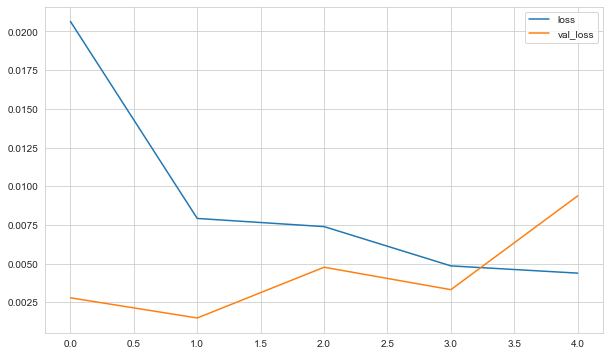

In [61]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [62]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model2.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [63]:
true_predictions = scaler.inverse_transform(test_predictions)

In [64]:
test['Predictions'] = true_predictions

In [65]:
test

Production  Predictions
DATE                               
2018-04-01     112.431      127.101
2018-05-01     110.354      135.767
2018-06-01     124.584      139.762
2018-07-01     117.222      137.330
2018-08-01     112.678      127.793
2018-09-01     103.312      112.168
2018-10-01      92.132       98.975
2018-11-01      82.435       87.844
2018-12-01      76.761       86.064
2019-01-01      86.999       94.666
2019-02-01      98.112      109.064
2019-03-01     116.172      125.862
2019-04-01     114.970      141.731
2019-05-01     114.561      152.587
2019-06-01     124.960      157.559
2019-07-01     110.263      155.246
2019-08-01     102.609      144.807
2019-09-01     101.587      126.908

<AxesSubplot:xlabel='DATE'>

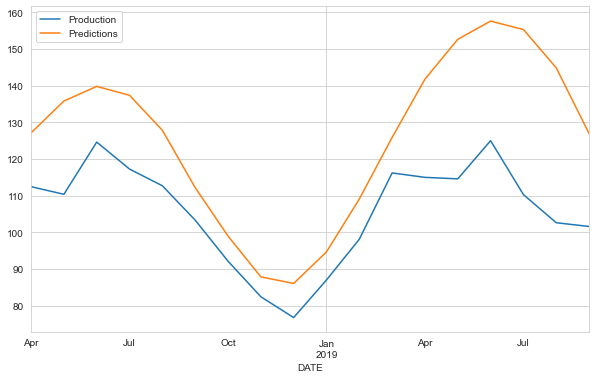

In [66]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [67]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [68]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: -2.0269437249463813 
mae: 19.94958696120861 
mse: 550.4413738955174 
rmse: 23.461487035043568


## Retrain and Forecasting

In [69]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [70]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [71]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
555/555 [==============================] - 8s 9ms/step - loss: 0.0252
Epoch 2/8
555/555 [==============================] - 6s 10ms/step - loss: 0.0083
Epoch 3/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0042
Epoch 4/8
555/555 [==============================] - 6s 10ms/step - loss: 0.0035
Epoch 5/8
555/555 [==============================] - 7s 12ms/step - loss: 0.0032
Epoch 6/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0028
Epoch 7/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0030
Epoch 8/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0026


In [72]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [73]:
forecast = scaler.inverse_transform(forecast)

In [74]:
forecast

array([[ 91.09255254],
       [ 83.38834881],
       [ 83.08003255],
       [ 94.31380102],
       [105.34493029],
       [113.97773638],
       [120.51253375],
       [124.54227356],
       [124.92808946],
       [120.78607855],
       [112.7466434 ],
       [103.02285475]])

In [75]:
df

Production
DATE                  
1972-01-01      59.962
1972-02-01      67.061
1972-03-01      74.235
1972-04-01      78.112
1972-05-01      84.764
...                ...
2019-05-01     114.561
2019-06-01     124.960
2019-07-01     110.263
2019-08-01     102.609
2019-09-01     101.587

[573 rows x 1 columns]

In [76]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [77]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [78]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [79]:
forecast_df

Forecast
2019-10-01    91.093
2019-11-01    83.388
2019-12-01    83.080
2020-01-01    94.314
2020-02-01   105.345
2020-03-01   113.978
2020-04-01   120.513
2020-05-01   124.542
2020-06-01   124.928
2020-07-01   120.786
2020-08-01   112.747
2020-09-01   103.023

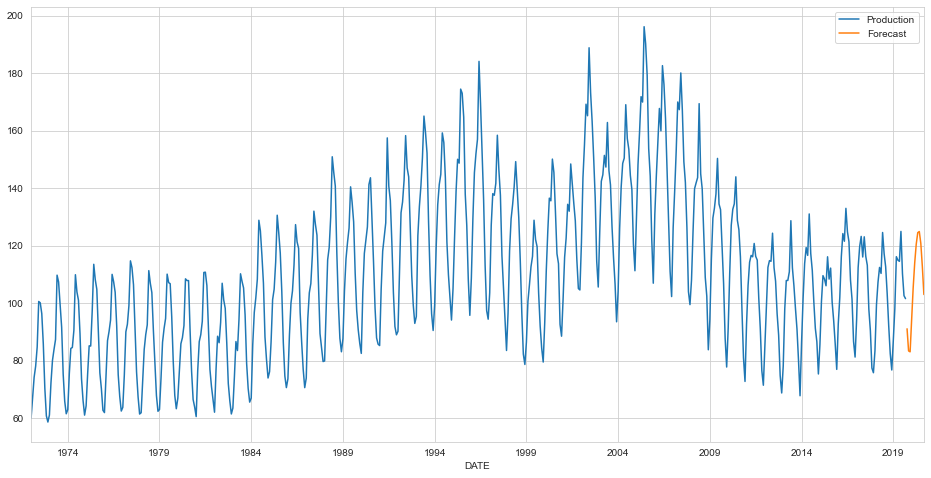

In [80]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 608.0)

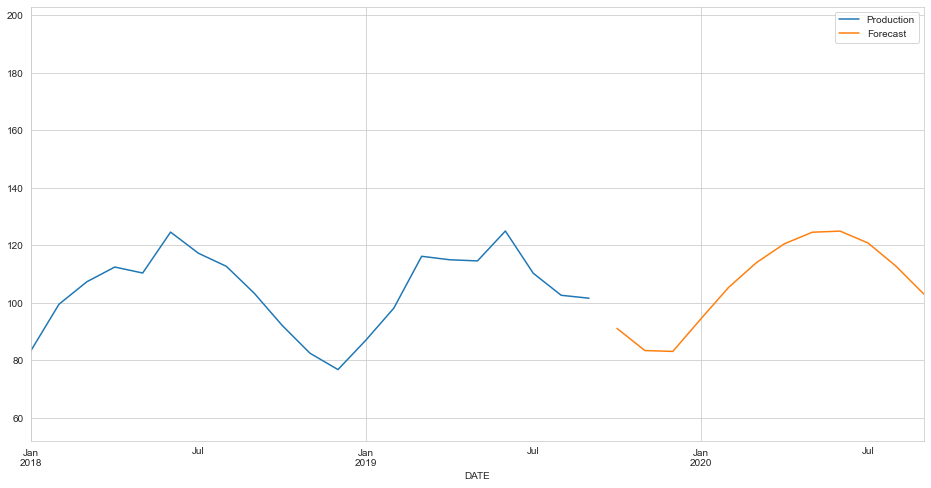

In [81]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-09-01')